In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import os

#Блокировки случайных генераторов

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import shutil #Библиотека для работы с файлами
from tqdm import tqdm #Библиотека отслеживания загрузки

data_root = 'D:\All_datasets\lego_components' #Корневая директория

train_dir = 'train' # Директория тренировочная
val_dir = 'val'# Валидационная

class_names = ['gear', 'gray_brick','ramp','red_brick','shaft'] #Имена классов по названиям папок

for dir_name in [train_dir, val_dir]: #Создаём директории под тренировочный и валидационный датасет
    for class_name in class_names: #Цикл по назавниям классов
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True) #Создаём

        
        #Каждое 6 ое изображение из тренировочного датасета забираем в валидационнный
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name) #Ресурсная папка
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))): #нумератор
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) #Отправляем в тренировочный под-датасет
        else:
            dest_dir = os.path.join(val_dir, class_name)#Отправляем в валидационный под-датасет
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 40.62it/s]


In [3]:

import numpy as np
import torchvision
import matplotlib.pyplot as plt #Библиотека графиков
import time
import copy

#Задаём параметры трансформации изображений при загрузке

from torchvision import transforms, models
train_transforms = transforms.Compose([ #Для тренировочного датасета
    transforms.Resize((224, 224)), # Изменение размера для подачи на вход сети
    transforms.RandomHorizontalFlip(), # Случайное горизонтальное отражение
    transforms.RandomVerticalFlip(), # Вертикальное горизонтальное отражение
    transforms.ToTensor(), #Преобразование в тензор
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Нормализация
])

val_transforms = transforms.Compose([ #Для валидационного
    transforms.Resize((224, 224)),# Изменение размера для подачи на вход сети
    transforms.ToTensor(),#Преобразование в тензор
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms) #Задаём откуда брать изображения и как менять
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms) #Задаём откуда брать изображения и как менять

batch_size = 20 #Размер батча(сколько изображений загружать в память для подачи в сеть)

#Если программа не работает можно попробывать уменьшить размер батча

train_dataloader = torch.utils.data.DataLoader( #Создаём загрузчик и с рядом параметров
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
#Параметры(название податасета,размер батча,перемешивание,количество обработчиков)

len(train_dataloader), len(train_dataset)
# Выводим количество батчей и изображений в тренировочном датасете

(15, 290)

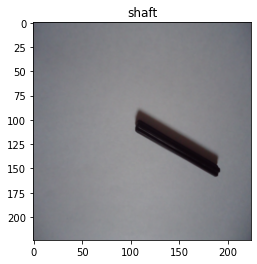

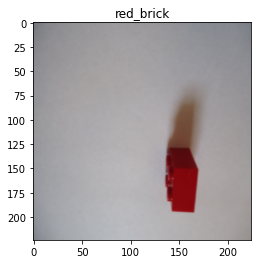

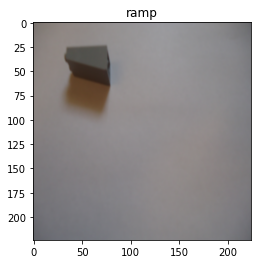

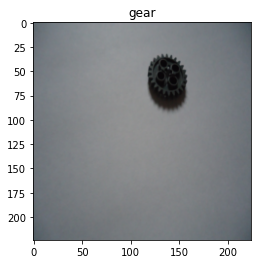

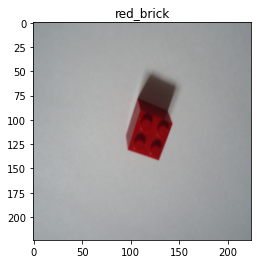

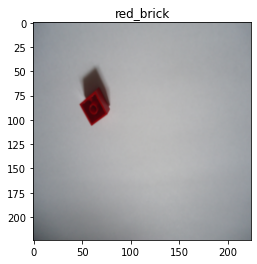

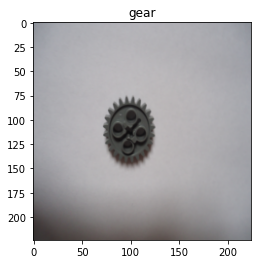

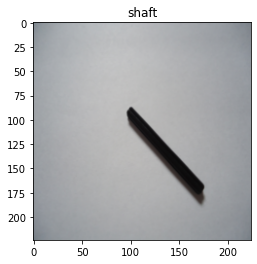

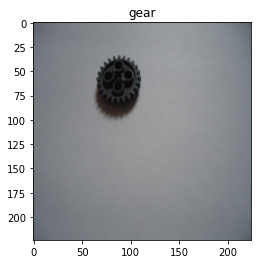

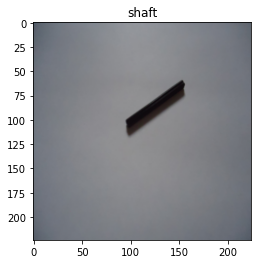

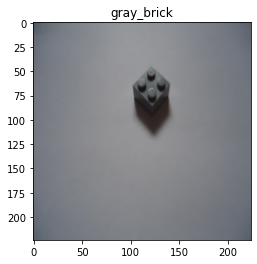

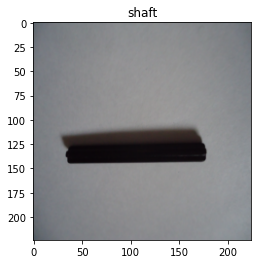

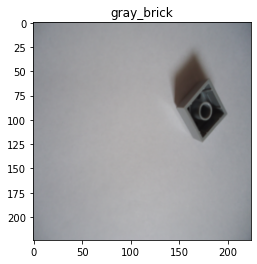

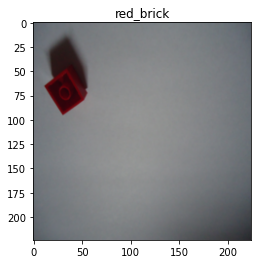

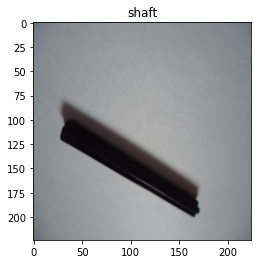

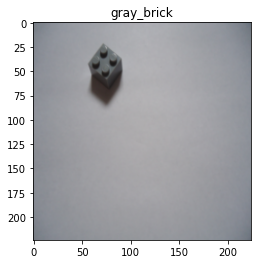

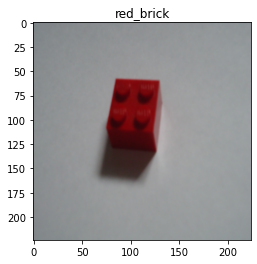

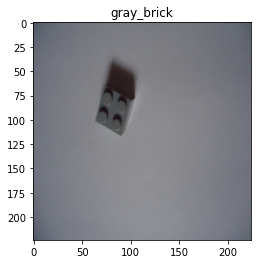

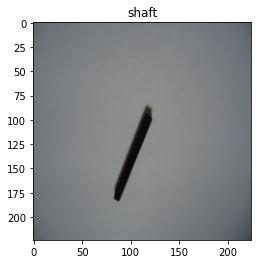

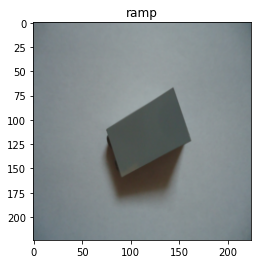

In [4]:
#Выводим одно случайное изображение
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);
#Убираем нормализацию, чтобы получить исходное изображение

#Вывод батча изображений с названиями классов
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [5]:
#Процедура обучения(модель,оптимизатор,планировщик шага,количество эпох)
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    since = time.time()
    
    val_accuracy_history = [] #История точности на валидационном под-датасете
    val_loss_history = [] #История потерь на валидационном под-датасете
    train_accuracy_history = [] #История точности на тренировочном под-датасете
    train_loss_history = [] #История потерь на тренировочном под-датасете
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        # В каждой эпохе есть тренеровочная и валидационная фаза
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader #Подаём тренеровочный датасет в загрузчик
                scheduler.step() #Шаг планировщика шага
                model.train()  # Переключить модель в тренировочный режим
            else:
                dataloader = val_dataloader #Подаём валидационный датасет в загрузчик
                model.eval()   # Переключить модель в валидационный режим

            running_loss = 0. #Задаём переменную текущего значения потерь
            running_acc = 0. #Задаём переменную текущего значения точности

            # Iterate over data. Итерируемся по данным
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) #Переносимм на ГПУ изобажения
                labels = labels.to(device) #Переносимм на ГПУ метки

                optimizer.zero_grad() #Обнуляем градиент

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'): #включаем расчёт градиента(фаза тренеровочная)
                    preds = model.forward(inputs) #Делаем форвард .forward Для своей модели
                    loss_value = loss(preds, labels) #Расчитываем значение целевой функции
                    preds_class = preds.argmax(dim=1) #Принемаем индекс класса как максимум от предсказаний

                    # backward + optimize only if in training phase
                    if phase == 'train': #Если тернировочная фаза то
                        loss_value.backward() #Делаем бэкворд
                        optimizer.step() #шаг оптимизатора
                        #scheduler.step()

                # statistics
                running_loss += loss_value.item() #Накопление лосса
                running_acc += (preds_class == labels.data).float().mean() #Расчёт точности

            epoch_loss = running_loss / len(dataloader) # Среднее значение потерь по эпохе
            epoch_acc = running_acc / len(dataloader) # Среднее значение точности по эпохе
            
            if phase == 'train': #Если фаза тренировочная, то записываем значения по эпохе для графика
                train_accuracy_history.append(epoch_acc) # Точность на тренировочных данных
                train_loss_history.append(epoch_loss) # Потери на тренировочных данных
            else:
                val_accuracy_history.append(epoch_acc) # Точность на валидационных данных
                val_loss_history.append(epoch_loss) # Точность на валидационных данных
            #Выводим фазу потери по эпохе и точность по эпохе
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True) 
            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    return model, val_accuracy_history, val_loss_history, train_accuracy_history, train_loss_history

In [7]:
# Модель transfer learning

model = models.resnet18(pretrained=True) #Загрузка стандартной модели

for param in model.parameters(): #Изменение параметров нейронной сети
    param.requires_grad = False #Отклюение градиента False - отключить, True - включить

model.fc = torch.nn.Linear(model.fc.in_features, 5) #Создаём новый слой вместо выходного 

#Второй агрумент функции должен быть равен количеству классов

#print(dir(torch.nn.Linear)) #Смотрим что внутри класса

In [8]:
# Параметры обучения

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 #Нужно, чтобы не включалась блокировка видеокарты
CUDA_LAUNCH_BLOCKING=1
model = model.to(device) #Переносим модель в гпу

loss = torch.nn.CrossEntropyLoss() #Задаём функцию потерь
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) #Задаём оптимизатор

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #Задаём планировщик шага

In [9]:
#Вызов процедуры обучения

val_acc = {}
val_loss = {}
train_acc = {}
train_loss = {}

start_time = time.time()

model, val_acc['val_acc'], val_loss['val_loss'], train_acc['train_acc'], train_loss['train_loss'] = \
train_model(model, loss, optimizer, scheduler, num_epochs=10); #Вызываем обучение
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/9:


C:\Users\User\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:54<00:00,  3.64s/it]

train Loss: 1.3936 Acc: 0.4767



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.56s/it]

val Loss: 1.0294 Acc: 0.7333
Epoch 1/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:51<00:00,  3.45s/it]

train Loss: 0.8574 Acc: 0.8300



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.51s/it]

val Loss: 0.6291 Acc: 0.9500
Epoch 2/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:52<00:00,  3.47s/it]

train Loss: 0.6546 Acc: 0.8733



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.66s/it]

val Loss: 0.4639 Acc: 0.9167
Epoch 3/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:51<00:00,  3.45s/it]

train Loss: 0.5073 Acc: 0.8967



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.51s/it]

val Loss: 0.3407 Acc: 0.9500
Epoch 4/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:52<00:00,  3.47s/it]

train Loss: 0.4000 Acc: 0.9267



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.39s/it]

val Loss: 0.2975 Acc: 0.9500
Epoch 5/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:51<00:00,  3.41s/it]

train Loss: 0.4201 Acc: 0.8800



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.52s/it]

val Loss: 0.2779 Acc: 0.9167
Epoch 6/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:51<00:00,  3.45s/it]

train Loss: 0.3570 Acc: 0.9267



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.47s/it]

val Loss: 0.2626 Acc: 0.9333
Epoch 7/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:52<00:00,  3.47s/it]

train Loss: 0.3136 Acc: 0.9467



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.61s/it]

val Loss: 0.2590 Acc: 0.9500
Epoch 8/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:51<00:00,  3.43s/it]

train Loss: 0.3119 Acc: 0.9400



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.50s/it]

val Loss: 0.2498 Acc: 0.9500
Epoch 9/9:



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:51<00:00,  3.40s/it]

train Loss: 0.3079 Acc: 0.9400



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.55s/it]

val Loss: 0.2450 Acc: 0.9500
Training complete in 10m 26s
--- 625.5295717716217 seconds ---


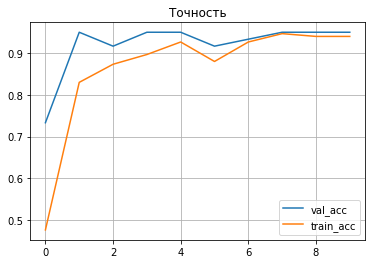

In [10]:
#График точности

for experiment_id in val_acc.keys():
    plt.plot(val_acc[experiment_id], label=experiment_id)
plt.legend()

for experiment_id in train_acc.keys():
    plt.plot(train_acc[experiment_id], label=experiment_id)
plt.legend()
plt.grid(True)
plt.title('Точность');

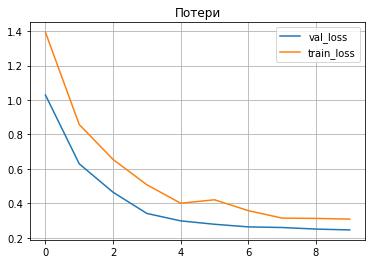

In [11]:
#График потерь

for experiment_id in val_loss.keys():
    plt.plot(val_loss[experiment_id], label=experiment_id)
plt.legend()


for experiment_id in train_loss.keys():
    plt.plot(train_loss[experiment_id], label=experiment_id)
plt.legend()
plt.grid(True)
plt.title('Потери');

Испытание на тестовом датасете и вывод готовой модели в файл

In [12]:

test_dir = 'D:\\All_datasets\\lego_components\\test' #Директория с тестовыми изображениями 

class_names = ['gear', 'gray_brick','ramp','red_brick','shaft'] #Классы изображений

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = torchvision.datasets.ImageFolder(test_dir, train_transforms)

batch_size = 10
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) #Если участок не работает 
#Стоит заменить num_workers на 0, можно попробывать взять число поменьше

model = model.to(device) #Передаём модель на ГПУ

len(test_dataloader),len(test_dataset)

(15, 150)

In [13]:
dataloader = test_dataloader #Проверяем по тестовому датасету
running_acc = 0
running_loss = 0

loss = torch.nn.CrossEntropyLoss()
model.eval()

for inputs, labels in tqdm(dataloader):
    inputs = inputs.to(device) #Переносимм на ГПУ изобажения
    labels = labels.to(device) #Переносимм на ГПУ метки
    
    preds = model(inputs) #Подаём изображение на вход и получаем предсказания сети
    loss_value = loss(preds, labels)
    preds_class = preds.argmax(dim=1)
    
    loss_value.backward()
    
    running_loss += loss_value.item()
    running_acc += (preds_class == labels.data).float().mean()
    
test_loss = running_loss / len(dataloader)
test_acc = running_acc / len(dataloader)
print('Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc), flush=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:28<00:00,  1.87s/it]

Loss: 0.2800 Acc: 0.9267


[[30  0  0  0  0]
 [ 0 21  9  0  0]
 [ 0  1 29  0  0]
 [ 0  0  0 30  0]
 [ 0  0  1  0 29]]


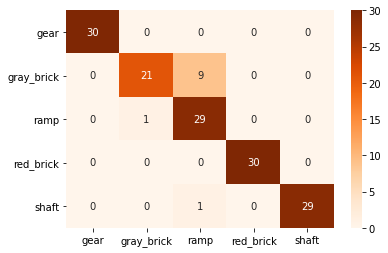

In [14]:
from sklearn import metrics
true_labels=[]
pred_labels=[]
for inputs, labels in test_dataloader:
  pred = model.forward(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
from pandas import DataFrame
import seaborn as sn
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

#Выгружаем обученную модель в ONNX

from torch.autograd import Variable
import torch.onnx
from __future__ import print_function, division

model=model.to("cpu") #Необходимо перевести модель обратно на ЦП, чтобы можно было сохранить модель

dir='D:\Models_nn' #Пример директории, предпологается что папка заренее создана

PATH =os.path.join(dir, "my_resnet50.onnx") #Название модели
dummy_input = Variable(torch.randn(1, 3, 224, 224)) #Размерность входа
#(количество изображений, количество каналов, ширина,высота изображения)
torch.onnx.export(model, dummy_input, PATH)

In [15]:

from torchsummary import summary #Полная информация о модели
model=model.to("cuda:0")
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
#Выгружаем обученную модель
model.eval()
model=model.to(torch.device("cpu"))
input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model,input_tensor)
NAME='lego_net.pt'

dir='D:\Models_nn'
path=os.path.join(dir,NAME)
script_model.save(path)

In [18]:
del model